In [155]:
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 
import scanpy as sc
import scipy as sp
import numpy as np
import pySingleCellNet as pySCN
import celloracle as co
from celloracle import motif_analysis as ma
import anndata

import warnings
warnings.filterwarnings(action='once')

co.check_python_requirements()
co.test_R_libraries_installation()

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300
save_folder = "figures"
os.makedirs(save_folder, exist_ok=True)

### Q3 - Mouse data

In [2]:
adata = sc.read_h5ad('./direct_conversion_subsampled_5k_raw.h5ad')
adata

AnnData object with n_obs × n_vars = 5000 × 33595
    obs: 'batch'

In [3]:
ref = sc.read_h5ad('./TM_FACS_heart.h5ad')
ref

AnnData object with n_obs × n_vars = 4337 × 23433
    obs: 'cell', 'cell_ontology_class', 'cell_ontology_id', 'cluster.ids', 'mouse.id', 'mouse.sex', 'plate.barcode', 'subtissue', 'tissue'

In [ ]:
# Find common genes
genesTrain = ref.var_names
genesdat = adata.var_names
cgenes = genesTrain.intersection(genesdat)
adTrain = ref[:,cgenes]
adQuery = adata[:,cgenes].copy()
# Split reference data into training and validation data
expT, expV = pySCN.splitCommonAnnData(adTrain, ncells=250, dLevel='cell_ontology_class')

In [ ]:
# Train classifier
[cgenesA, xpairs, tspRF] = pySCN.scn_train(expT, nTopGenes=100, nRand=100, nTrees=1000, nTopGenePairs=100, dLevel='cell_ontology_class', stratify=True, limitToHVG=True)

In [ ]:
# Apply classifier on validation data
adVal = pySCN.scn_classify(expV, cgenesA, xpairs, tspRF, nrand=0)
sc.pl.heatmap(adVal, adVal.var_names.values, groupby='SCN_class', cmap='viridis', dendrogram=False, swap_axes=True, figsize=(20,5))

In [ ]:
# Assess classifier performance and plot PR curve
assessment = pySCN.assess_comm(expT, adVal, resolution=0.005, nRand=0, dLevelSID='cell', classTrain='cell_ontology_class', classQuery='cell_ontology_class')
pySCN.plot_PRs(assessment)

In [ ]:
assessment['accuracy']

In [ ]:
# Classify query data
ad = pySCN.scn_classify(adQuery, cgenesA, xpairs, tspRF, nrand=0)
sc.pl.heatmap(ad, ad.var_names.values, groupby='SCN_class', cmap='viridis', dendrogram=False, swap_axes=True, figsize=(20,5))
pySCN.add_classRes(adQuery, ad)

In [ ]:
adCM = adQuery[adQuery.obs['SCN_class'] == 'cardiac muscle cell']
adCM

In [4]:
kannan = sc.read('./Kannan_perinatal_reference.h5ad')
kannan

AnnData object with n_obs × n_vars = 936 × 29593
    obs: 'i7', 'cellbarcode', 'column', 'timepoint', 'genes', 'umis', 'ERCC_percent', 'reads'

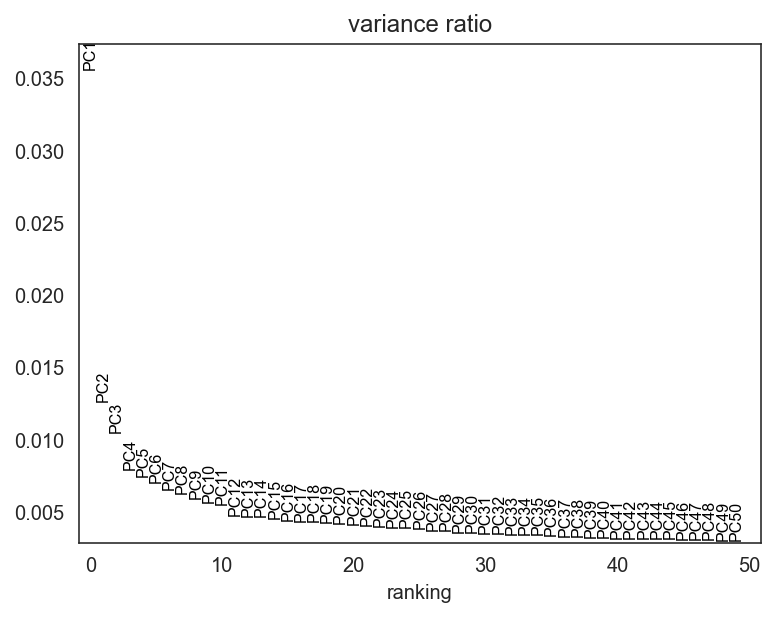

In [5]:
sc.pp.filter_genes(kannan, min_counts=1)
sc.pp.normalize_per_cell(kannan, key_n_counts='n_counts_all')
filter_result = sc.pp.filter_genes_dispersion(kannan.X, flavor='cell_ranger', n_top_genes=2000, log=False)
keep = np.add(filter_result.gene_subset, kannan.var_names=='Prdm16')
keep = np.add(keep, kannan.var_names=='E2f2')
keep = np.add(keep, kannan.var_names=='Gata4')
keep = np.add(keep, kannan.var_names=='Tbx5')
kannan = kannan[:, keep]
sc.pp.normalize_per_cell(kannan)
kannan.raw = kannan
kannan.layers["raw_count"] = kannan.raw.X.copy()
sc.pp.log1p(kannan)
sc.pp.scale(kannan)
sc.tl.pca(kannan)
sc.pl.pca_variance_ratio(kannan, 50)

In [6]:
sc.pp.neighbors(kannan, n_neighbors=15, n_pcs=15)

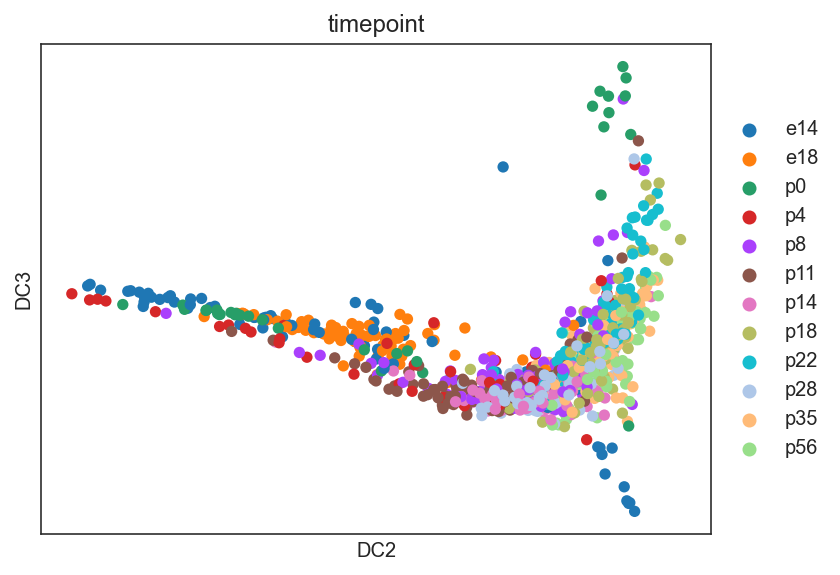

In [8]:
sc.pp.neighbors(kannan, n_neighbors = 10)
#sc.pp.neighbors(kannan, n_neighbors = 10, use_rep = "X_diffmap")
sc.tl.diffmap(kannan)
sc.pl.diffmap(kannan, color='timepoint', components=['2,3'])

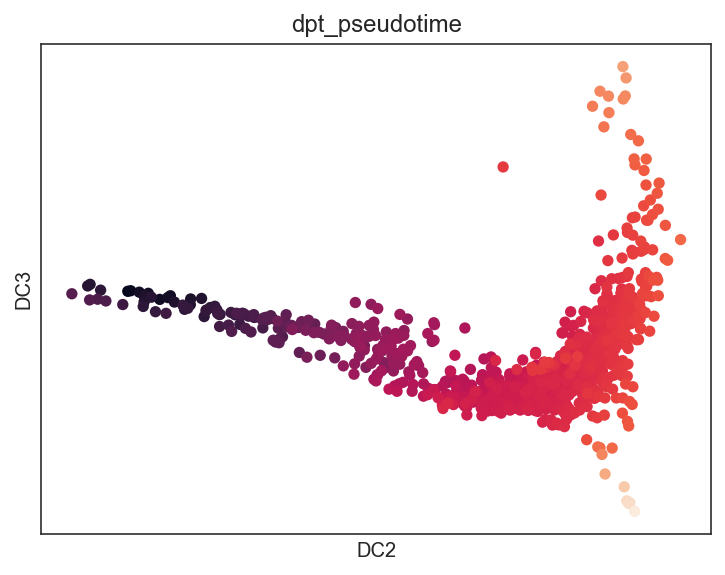

In [11]:
kannan.uns['iroot'] = np.flatnonzero(kannan.obs['timepoint'] == 'e14')[0]
sc.tl.dpt(kannan, n_branchings = 0)
sc.pl.diffmap(kannan, color='dpt_pseudotime', components=['2,3'], use_raw=False, colorbar_loc=None)

In [117]:
sc.set_figure_params(figsize='10,4')
sc.tl.rank_genes_groups(kannan, groupby='timepoint', use_raw=False)
matureCM_glist = sc.get.rank_genes_groups_df(kannan, group=['p56']).sort_values(by = ["pvals_adj"])

In [118]:
matureCM_glist[matureCM_glist.pvals_adj < 0.01]

,names,scores,logfoldchanges,pvals,pvals_adj
2003,Eef1a1,-19.547667,-57.483273,3.398318e-71,6.810230e-68
2002,Actc1,-18.321301,-301.772125,6.023772e-50,6.035820e-47
2001,Tnni1,-15.244740,-101.295486,7.127472e-47,4.761151e-44
1999,Slc8a1,-14.213249,-55.017555,1.030012e-40,5.160361e-38
1998,Myh7,-13.226634,-126.115158,1.013256e-36,4.061131e-34
...,...,...,...,...,...
1808,Disc1,-3.313358,-3.935294,9.579097e-04,9.184933e-03
1806,Ebf2,-3.305710,-3.609479,9.836649e-04,9.386973e-03
1807,Tsta3,-3.309769,-2.859599,1.006244e-03,9.556934e-03
1805,Actr5,-3.295909,-3.905282,1.018910e-03,9.631586e-03


In [221]:
# Select differentially expressed genes in matured CMs in reference data(Kannan et al)
matureCM_dge = matureCM_glist[matureCM_glist.pvals_adj < 0.01]
matureCM_dge_list = matureCM_dge.nameifwes.tolist()

In [12]:
# Load cell oracle built-in base GRN from mouse cell atlas dataset
base_GRN = co.data.load_mouse_scATAC_atlas_base_GRN()
base_GRN.head()

,peak_id,gene_short_name,9430076c15rik,Ac002126.6,Ac012531.1,Ac226150.2,Afp,Ahr,Ahrr,Aire,...,Znf784,Znf8,Znf816,Znf85,Zscan10,Zscan16,Zscan22,Zscan26,Zscan31,Zscan4
0,chr10_100050979_100052296,4930430F08Rik,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,chr10_101006922_101007748,SNORA17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,chr10_101144061_101145000,Mgat4c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,chr10_10148873_10149183,9130014G24Rik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,chr10_10149425_10149815,9130014G24Rik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# Instantiate Oracle object
oracle = co.Oracle()
kannan.X = kannan.raw.X
oracle.import_anndata_as_raw_count(adata=kannan, cluster_column_name="timepoint", embedding_name="X_pca")

# Load base GRN into oracle object
oracle.import_TF_data(TF_info_matrix=base_GRN)

In [14]:
# Train model on training dataset
oracle.perform_PCA()
n_comps = 50
n_cell = oracle.adata.shape[0]
k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")
oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8,
                      b_maxl=k*4, n_jobs=4)

Auto-selected k is :23


In [15]:
# Calculate GRN for each timepoint 
warnings.filterwarnings('ignore') #Otherwise, np.int nightmare
links = oracle.get_links(cluster_name_for_GRN_unit="timepoint", alpha=10,
                         verbose_level=10, test_mode=False, n_jobs=-1)

  0%|          | 0/12 [00:00<?, ?it/s]

inferring GRN for e14...


  0%|          | 0/1314 [00:00<?, ?it/s]

inferring GRN for e18...


  0%|          | 0/1314 [00:00<?, ?it/s]

inferring GRN for p0...


  0%|          | 0/1314 [00:00<?, ?it/s]

inferring GRN for p11...


  0%|          | 0/1314 [00:00<?, ?it/s]

inferring GRN for p14...


  0%|          | 0/1314 [00:00<?, ?it/s]

inferring GRN for p18...


  0%|          | 0/1314 [00:00<?, ?it/s]

inferring GRN for p22...


  0%|          | 0/1314 [00:00<?, ?it/s]

inferring GRN for p28...


  0%|          | 0/1314 [00:00<?, ?it/s]

inferring GRN for p35...


  0%|          | 0/1314 [00:00<?, ?it/s]

inferring GRN for p4...


  0%|          | 0/1314 [00:00<?, ?it/s]

inferring GRN for p56...


  0%|          | 0/1314 [00:00<?, ?it/s]

inferring GRN for p8...


  0%|          | 0/1314 [00:00<?, ?it/s]

In [16]:
# Filter network edges
links.filter_links(p=0.001, weight="coef_abs", threshold_number=2000)
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(alpha=10, use_cluster_specific_TFdict=True)

fitting GRN again...
calculating GRN in e14


  0%|          | 0/2004 [00:00<?, ?it/s]

genes_in_gem: 2004
models made for 509 genes
calculating GRN in e18


  0%|          | 0/2004 [00:00<?, ?it/s]

genes_in_gem: 2004
models made for 483 genes
calculating GRN in p0


  0%|          | 0/2004 [00:00<?, ?it/s]

genes_in_gem: 2004
models made for 434 genes
calculating GRN in p11


  0%|          | 0/2004 [00:00<?, ?it/s]

genes_in_gem: 2004
models made for 487 genes
calculating GRN in p14


  0%|          | 0/2004 [00:00<?, ?it/s]

genes_in_gem: 2004
models made for 443 genes
calculating GRN in p18


  0%|          | 0/2004 [00:00<?, ?it/s]

genes_in_gem: 2004
models made for 444 genes
calculating GRN in p22


  0%|          | 0/2004 [00:00<?, ?it/s]

genes_in_gem: 2004
models made for 442 genes
calculating GRN in p28


  0%|          | 0/2004 [00:00<?, ?it/s]

genes_in_gem: 2004
models made for 453 genes
calculating GRN in p35


  0%|          | 0/2004 [00:00<?, ?it/s]

genes_in_gem: 2004
models made for 486 genes
calculating GRN in p4


  0%|          | 0/2004 [00:00<?, ?it/s]

genes_in_gem: 2004
models made for 481 genes
calculating GRN in p56


  0%|          | 0/2004 [00:00<?, ?it/s]

genes_in_gem: 2004
models made for 466 genes
calculating GRN in p8


  0%|          | 0/2004 [00:00<?, ?it/s]

genes_in_gem: 2004
models made for 464 genes


### Gata4 KO

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7e866e8a00>],
      dtype=object)

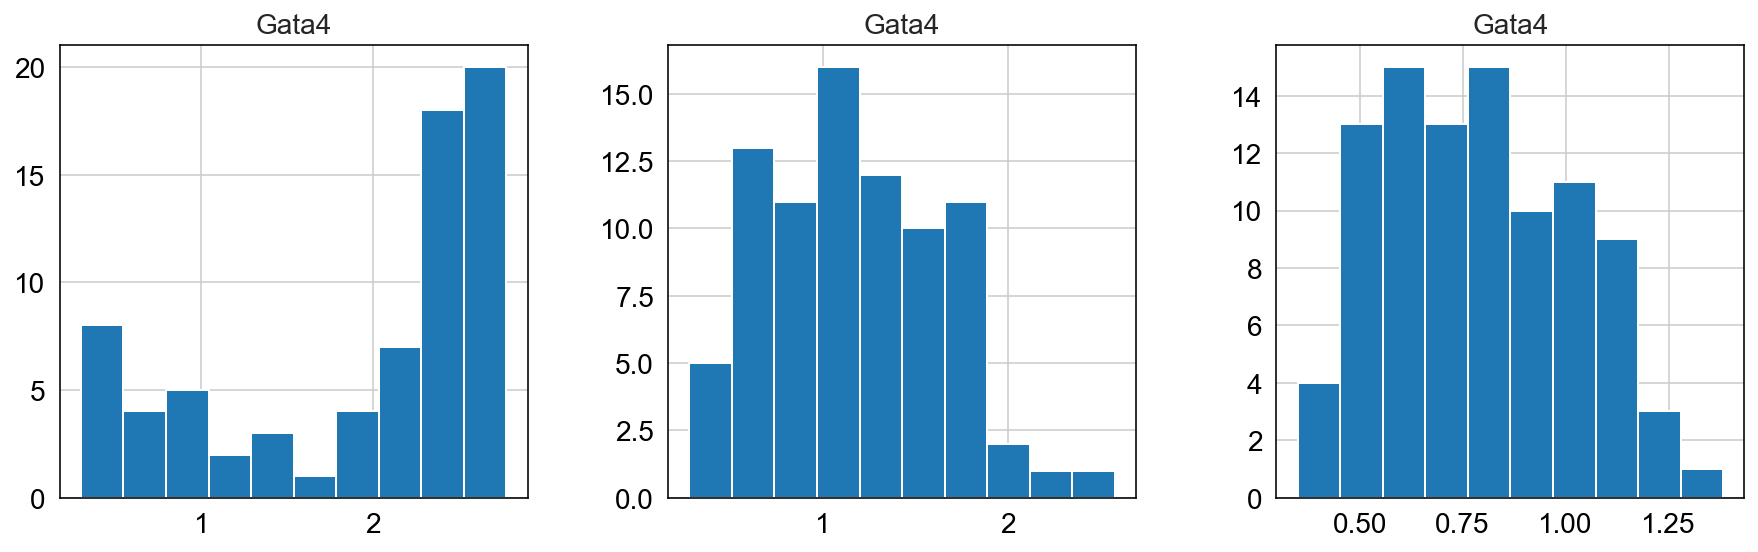

In [222]:
# Plot Gata4 expression before perturbation
fig, ax = plt.subplots(1, 3, figsize=[15, 4])
sc.get.obs_df(oracle.adata[oracle.adata.obs['timepoint'] == 'e14'], keys=['Gata4'], layer="imputed_count").hist(ax=ax[0])
sc.get.obs_df(oracle.adata[oracle.adata.obs['timepoint'] == 'p8'], keys=['Gata4'], layer="imputed_count").hist(ax=ax[1])
sc.get.obs_df(oracle.adata[oracle.adata.obs['timepoint'] == 'p56'], keys=['Gata4'], layer="imputed_count").hist(ax=ax[2])

In [223]:
# Set Gata4 expression to 0.0 to simulate knockout
oracle.simulate_shift(perturb_condition={'Gata4': 0.0}, n_propagation=3)

In [233]:
Gata4_KO_df = pd.DataFrame(oracle.adata.layers['delta_X'])
Gata4_KO_df.columns = kannan.var_names
Gata4_KO_df.index = kannan.obs.index
Gata4_KO_df.head()

,H19,Narf,Xpo6,Slfn4,Hddc2,Egfl6,Cttnbp2,Cd52,Hip1r,Mmp14,...,Gm18095,Gm49485,Gm36677,Gm41361,Gm49492,Gm41386,9430014N10Rik,Gm49475,Gm30567,Gm49463
AAGAGGCAAAAGTT,0.0,-0.095290,-0.104958,0.0,-0.032117,0.0,0.0,0.0,0.000000,-0.022697,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAGAGGCAATATAG,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,-0.096867,-0.142743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAGAGGCAATCAAA,0.0,-0.088443,-0.097417,0.0,-0.029809,0.0,0.0,0.0,0.000000,-0.021066,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAGAGGCAATGAAT,0.0,0.000000,-0.138670,0.0,-0.079933,0.0,0.0,0.0,-0.087040,-0.027244,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAGAGGCACCCACG,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,-0.094763,-0.139643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


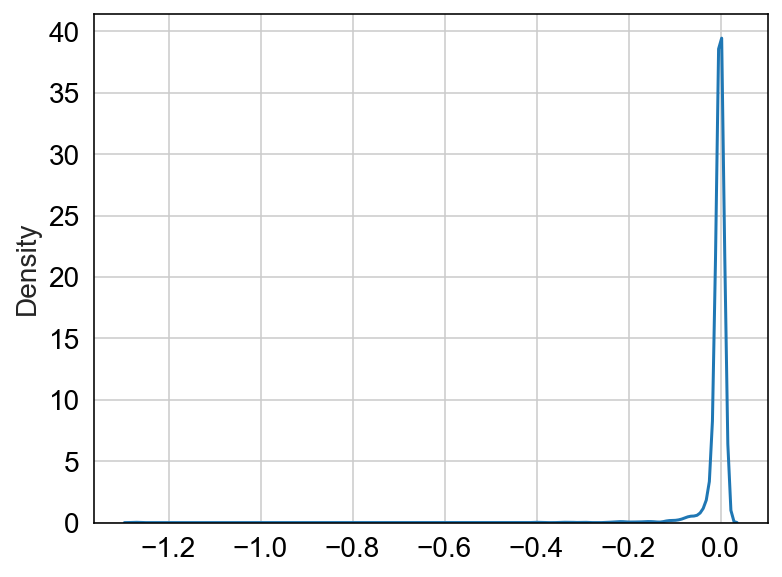

In [234]:
sns.kdeplot(Gata4_KO_df.mean())

In [235]:
sum(Gata4_KO_df.mean() > 0)

26

In [244]:
# Get genes that are overexpressed in CMs after simulation
Gata4_glist = []
for i in Gata4_KO_df.columns:
    if Gata4_KO_df[str(i)].mean() > 0:
        Gata4_glist.append(i)

In [245]:
# Genes overexpressed after Gata4 KO that overlaps with gene markers of mature CMs 
Gata4_glist = list(set(matureCM_dge_list) & set(Gata4_glist))
print(Gata4_glist)

['Cdc42se1', 'Stab1', 'Tmem9', 'Fth1', 'Cenpf', 'Myh6', 'Stxbp5']


In [292]:
# Pearson correlation of gene expression between reference CMs and engineered CMs
import scipy
scipy.stats.pearsonr(kannan[:,kannan.var_names.isin(['Cdc42se1', 'Stab1', 'Tmem9', 'Fth1', 'Cenpf', 'Myh6', 'Stxbp5'])].X.mean(axis=0),
                    Gata4_KO_df.loc[:,['Cdc42se1', 'Stab1', 'Tmem9', 'Fth1', 'Cenpf', 'Myh6', 'Stxbp5']].mean())

(-0.22137095255608938, 0.633329237556311)

The differential gene expression after Gata4 knockout simulation has a weak negative correlation with differential gene expression in matured cardiomyocytes, suggesting that upregulation of Gata4 might play a role in cardiomyocytes maturation. It is consistent with literature that deletion of Gata4 results in a decline in cardiac function.

### E2f2 KO

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7e8ad48eb0>],
      dtype=object)

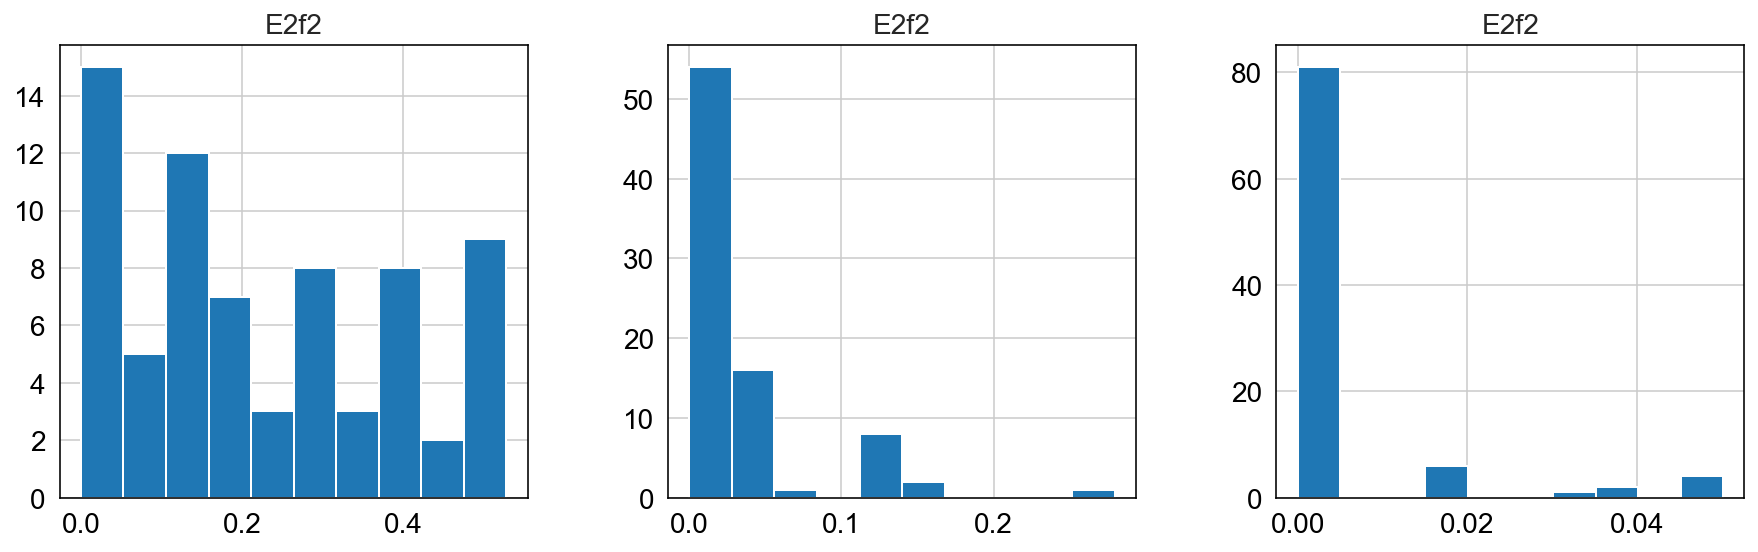

In [237]:
# Plot E2f2 expression before perturbation
fig, ax = plt.subplots(1, 3, figsize=[15, 4])
sc.get.obs_df(oracle.adata[oracle.adata.obs['timepoint'] == 'e14'], keys=['E2f2'], layer="imputed_count").hist(ax=ax[0])
sc.get.obs_df(oracle.adata[oracle.adata.obs['timepoint'] == 'p8'], keys=['E2f2'], layer="imputed_count").hist(ax=ax[1])
sc.get.obs_df(oracle.adata[oracle.adata.obs['timepoint'] == 'p56'], keys=['E2f2'], layer="imputed_count").hist(ax=ax[2])

In [328]:
# Set Gata4 expression to 0.0 to simulate knockout
oracle.simulate_shift(perturb_condition={'E2f2': 0.0}, n_propagation=3)

In [329]:
E2f2_KO_df = pd.DataFrame(oracle.adata.layers['delta_X'])
E2f2_KO_df.columns = kannan.var_names
E2f2_KO_df.index = kannan.obs.index
E2f2_KO_df.head()

,H19,Narf,Xpo6,Slfn4,Hddc2,Egfl6,Cttnbp2,Cd52,Hip1r,Mmp14,...,Gm18095,Gm49485,Gm36677,Gm41361,Gm49492,Gm41386,9430014N10Rik,Gm49475,Gm30567,Gm49463
AAGAGGCAAAAGTT,0.0,-0.000818,-0.004281,0.0,-0.002747,0.0,0.0,0.0,0.000000,-0.000227,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAGAGGCAATATAG,0.0,0.000000,-0.106959,0.0,-0.100493,0.0,0.0,0.0,-0.009516,-0.136869,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAGAGGCAATCAAA,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAGAGGCAATGAAT,0.0,0.000000,-0.000411,0.0,-0.000569,0.0,0.0,0.0,-0.000505,-0.000334,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAGAGGCACCCACG,0.0,0.000000,-0.122496,0.0,-0.115091,0.0,0.0,0.0,-0.010898,-0.156749,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


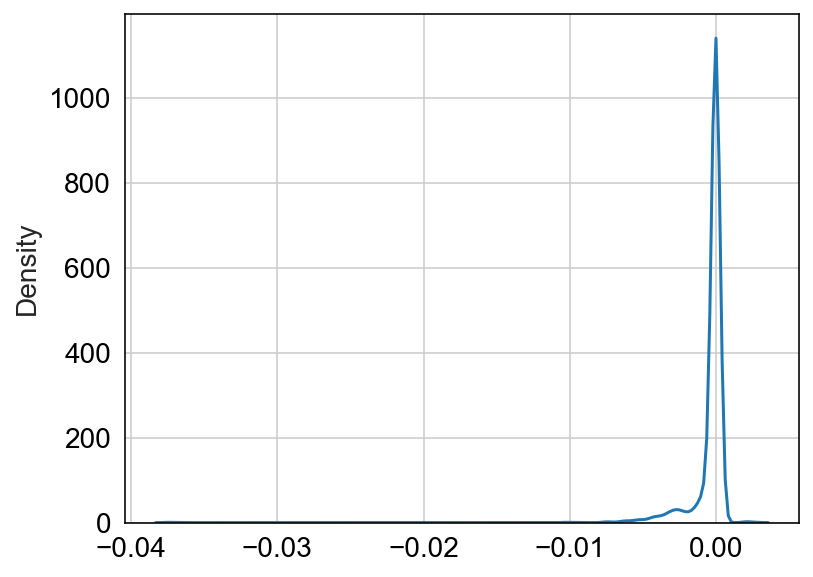

In [330]:
sns.kdeplot(E2f2_KO_df.mean())

In [335]:
sum(E2f2_KO_df.mean() > 0)

85

In [336]:
# Get genes that are overexpressed in CMs after simulation
E2f2_glist = []
for i in E2f2_KO_df.columns:
    if E2f2_KO_df[str(i)].mean() > 0:
        E2f2_glist.append(i)

In [337]:
# Genes overexpressed after E2f2 KO that overlaps with gene markers of mature CMs 
E2f2_glist = list(set(matureCM_dge_list) & set(E2f2_glist))
print(E2f2_glist)

['Fth1', 'Klhl31', 'Tcap', '2610035D17Rik', 'Ddr2', 'Myh6', 'Mtm1', 'Srsf4', 'Zfp830', 'Ttn']


In [338]:
# Pearson correlation of gene expression between reference CMs and engineered CMs
import scipy
scipy.stats.pearsonr(kannan[:,kannan.var_names.isin(E2f2_glist)].X.mean(axis=0),
                    Gata4_KO_df.loc[:,E2f2_glist].mean())

(0.20114099092272575, 0.577377349031407)

The differential gene expression after E2f2 knockout simulation has a weak positive correlation with differential gene expression in matured cardiomyocytes, which suggests that downregulation might contribute to cardiomyocyte maturation. It is consistent with E2f2's role in postnatal cardiomyocte maturation, as it has been shown that downregulation of E2f2 leads to cell cycle exit, a hallmark of cardiomyocyte maturation.

### Tbx5 KO

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7e70951f70>],
      dtype=object)

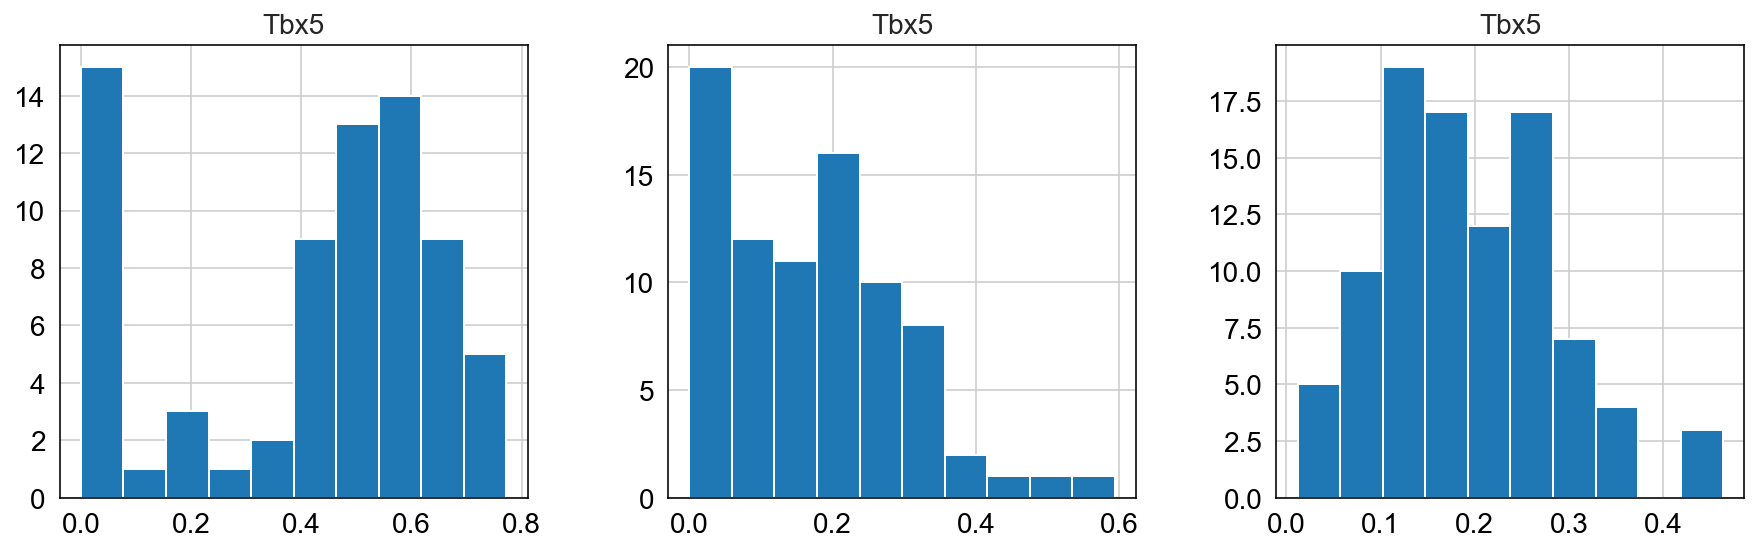

In [256]:
# Plot Tbx5 expression before perturbation
fig, ax = plt.subplots(1, 3, figsize=[15, 4])
sc.get.obs_df(oracle.adata[oracle.adata.obs['timepoint'] == 'e14'], keys=['Tbx5'], layer="imputed_count").hist(ax=ax[0])
sc.get.obs_df(oracle.adata[oracle.adata.obs['timepoint'] == 'p8'], keys=['Tbx5'], layer="imputed_count").hist(ax=ax[1])
sc.get.obs_df(oracle.adata[oracle.adata.obs['timepoint'] == 'p56'], keys=['Tbx5'], layer="imputed_count").hist(ax=ax[2])

In [313]:
# Set Tbx5 expression to 0.0 to simulate knockout
oracle.simulate_shift(perturb_condition={'Tbx5': 0.0}, n_propagation=3)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7e74369a60>],
      dtype=object)

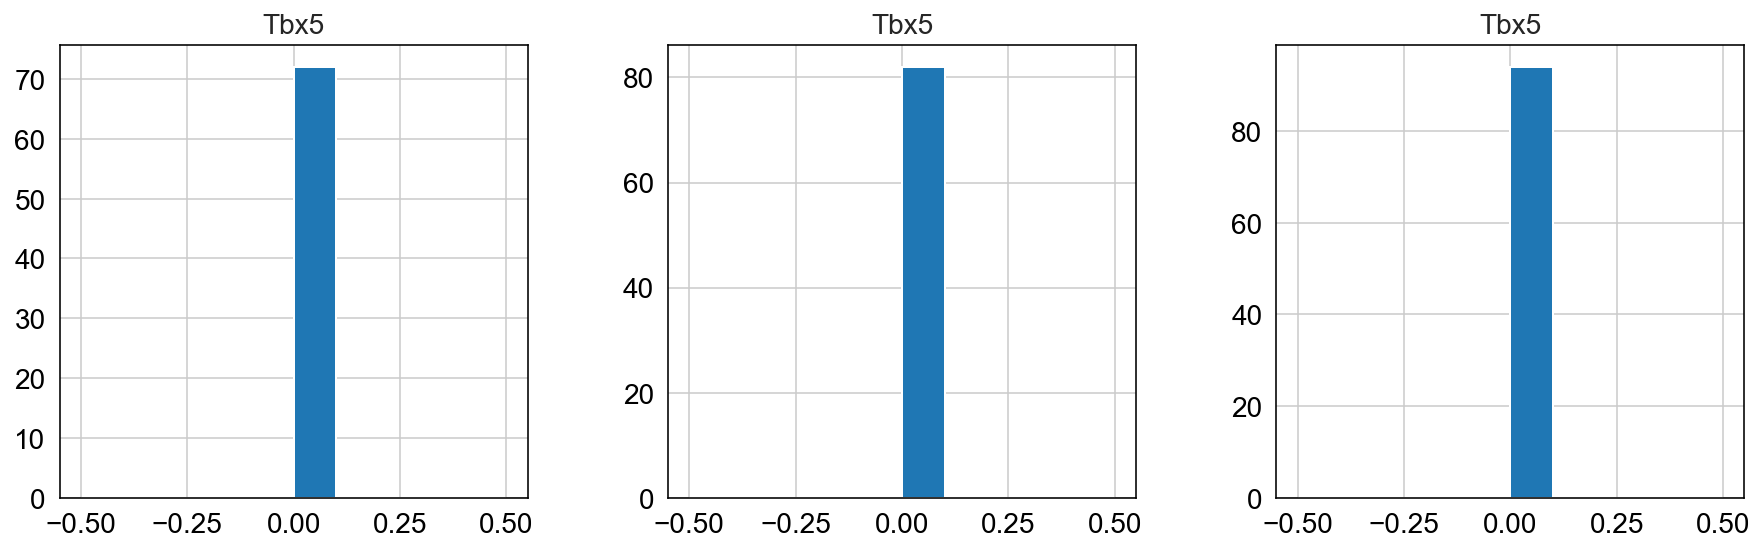

In [314]:
# Plot Tbx5 expression after perturbation
fig, ax = plt.subplots(1, 3, figsize=[15, 4])
sc.get.obs_df(oracle.adata[oracle.adata.obs['timepoint'] == 'e14'], keys=['Tbx5'], layer="simulated_count").hist(ax=ax[0])
sc.get.obs_df(oracle.adata[oracle.adata.obs['timepoint'] == 'p8'], keys=['Tbx5'], layer="simulated_count").hist(ax=ax[1])
sc.get.obs_df(oracle.adata[oracle.adata.obs['timepoint'] == 'p56'], keys=['Tbx5'], layer="simulated_count").hist(ax=ax[2])

In [315]:
Tbx5_KO_df = pd.DataFrame(oracle.adata.layers['delta_X'])
Tbx5_KO_df.columns = kannan.var_names
Tbx5_KO_df.index = kannan.obs.index
Tbx5_KO_df.head()

,H19,Narf,Xpo6,Slfn4,Hddc2,Egfl6,Cttnbp2,Cd52,Hip1r,Mmp14,...,Gm18095,Gm49485,Gm36677,Gm41361,Gm49492,Gm41386,9430014N10Rik,Gm49475,Gm30567,Gm49463
AAGAGGCAAAAGTT,0.0,-0.020375,0.000000,0.0,-0.004216,0.0,0.0,0.0,0.000000,-0.000488,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAGAGGCAATATAG,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,-0.000567,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAGAGGCAATCAAA,0.0,-0.029139,0.000000,0.0,-0.006030,0.0,0.0,0.0,0.000000,-0.000697,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAGAGGCAATGAAT,0.0,-0.105010,-0.001517,0.0,-0.010068,0.0,0.0,0.0,-0.003705,-0.001228,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAGAGGCACCCACG,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,-0.000437,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


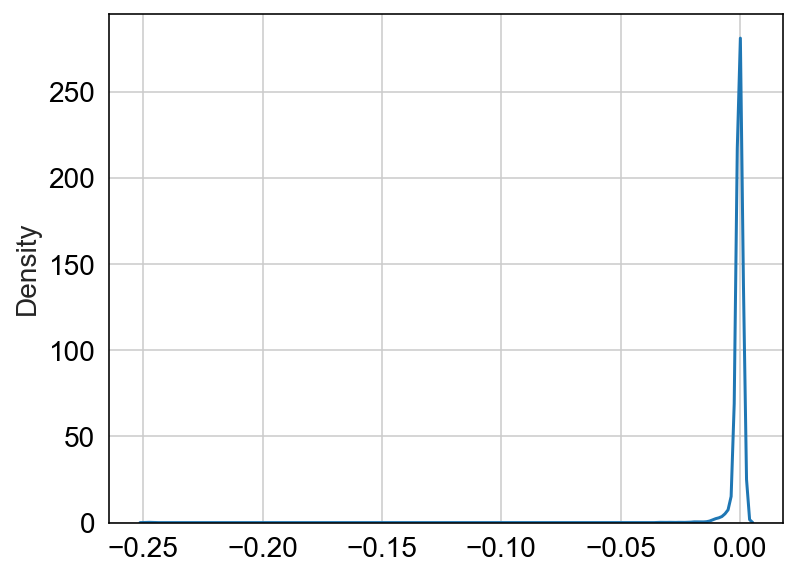

In [316]:
sns.kdeplot(Tbx5_KO_df.mean())

In [317]:
sum(Tbx5_KO_df.mean() > 0)

62

In [318]:
# Get genes that are overexpressed in CMs after simulation
Tbx5_glist = []
for i in Tbx5_KO_df.columns:
    if Tbx5_KO_df[str(i)].mean() > 0:
        Tbx5_glist.append(i)

In [319]:
# Genes overexpressed after Tbx5 KO that overlaps with gene markers of mature CMs 
Tbx5_glist = list(set(matureCM_dge_list) & set(Tbx5_glist))
print(Tbx5_glist)

['Fabp3', 'Wdr92', 'Gtf2h1', 'Socs5', 'Btbd6', 'Nup85', 'Dctn5', 'Rnf135', 'Zfp511', 'Racgap1']


In [320]:
# Pearson correlation of gene expression between reference CMs and engineered CMs
import scipy
scipy.stats.pearsonr(kannan[:,kannan.var_names.isin(Tbx5_glist)].X.mean(axis=0),
                    Gata4_KO_df.loc[:,Tbx5_glist].mean())

(0.1180501077651311, 0.74533411158237)

The differential gene expression after Tbx5 knockout simulation has a weak positive correlation with differential gene expression in matured cardiomyocytes, which suggests that downregulation might contribute to cardiomyocyte maturation. This is not consistent with experimental observations. Tbx5 plays a role in promoting conduction and ion channel homeostasis in postnatal cardiomyocytes, so we hypothesized that knockout of Tbx5 will inhibit cardiomyocyte maturation.